# Initialize

## Import functionality

In [5]:
from os.path import join
import math
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import spacy

## Load and merge sentiment data

* https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news
* https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
* https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

In [6]:
# Source folder
SOURCE_DATA_FOLDER = ['..','datasets']
# Data sets
SOURCE_DATA = {
    'AA':[['kaggle','ankurzing','SEntFiN-v1.1.csv'],'utf-8', False],
    'AS':[['kaggle','ankurzing','all-data.csv'],'ansi', False],
    'SB':[['kaggle','sbhatti','data.csv'],'utf-8', False]
}
# SOURCE_DATA processing functions
PROCESSORS = {}
# Dictionary of word to WStat instance
WORDS:dict = {}
# List of samples where each sample is a tuple[SAMPLE_SCORE,list[tuple[WORD,WORD_COUNT]]]
TEXTS:list = []

In [13]:
lang_proc = spacy.load("en_core_web_sm")
import en_core_web_sm
lang_proc = en_core_web_sm.load()

In [4]:
# Word statistics containing count and score where score is the sum of
# points. A point is -1, 0 or 1 (sentiment class).
class WStat:
    def __init__(self, score, count) -> None:
        self.score = score
        self.count = count
    def add(self, point, count):
        self.score += point
        self.count += count
    def get_score(self): return self.score
    def get_count(self): return self.count

In [33]:
#test
'''
src_key ='AA'
df = pd.read_csv(join(*SOURCE_DATA_FOLDER, *SOURCE_DATA[src_key][0]), encoding=SOURCE_DATA[src_key][1])
print(df)
for idx,row in df.iterrows():
    text = row['Title']
    doc = lang_proc(text)
    print(doc.text)
    print(doc.text_with_ws)
    if idx>20: break
'''

       S No.                                              Title  \
0          1  SpiceJet to issue 6.4 crore warrants to promoters   
1          2                  MMTC Q2 net loss at Rs 10.4 crore   
2          3  Mid-cap funds can deliver more, stay put: Experts   
3          4             Mid caps now turn into market darlings   
4          5  Market seeing patience, if not conviction: Pra...   
...      ...                                                ...   
10748  10749       Negative on Chambal, Advanta: Mitesh Thacker   
10749  10750     Small, Mid-cap stocks may emerge outperformers   
10750  10751                      Rupee slips against US dollar   
10751  10752                       Rupee weak against US dollar   
10752  10753                Australia shares flat; energy drags   

                                               Decisions  Words  
0                                {"SpiceJet": "neutral"}      8  
1                                    {"MMTC": "neutral"}      8

In [3]:
# Add sample words to 'dst' (WORDS) and 'txt' (TEXTS)
def add_words(point, words:list[str], dst:dict[WStat], txt:list):
    wmap = {}
    # histogram
    for w in words:
        if w in wmap: wmap[w] += 1
        else: wmap[w] = 1
    # add histogram entries to corresponding WStat
    for word,count in wmap.items():
        if word in dst:
            dst[word].add(point,count) # add to existing
        else:
            dst[word] = WStat(point,count) # new
    # append sample
    txt.append((point, wmap.items()))
# Process set ankurzing aspect-based.
def prep_ankurzing_asp(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row['Decisions']
        sentiment = sentiment[sentiment.find(':')+3]
        # score
        if sentiment=='p': point = 1
        elif sentiment=='n': point = -1
        else: point = 0
        # get text words
        add_words(point, row['Title'].lower().split(), dst, txt)
PROCESSORS['AA'] = prep_ankurzing_asp
# Process set ankurzing sentiment.
def prep_ankurzing_sent(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row[0]
        # score
        if sentiment=='positive': point = 1
        elif sentiment=='negative': point = -1
        else: point = 0
        # get text words
        add_words(point, row[1].lower().split(), dst, txt)
PROCESSORS['AS'] = prep_ankurzing_sent
# Process set sbhatti financial.
def prep_sbhatti(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row['Sentiment']
        # score
        if sentiment=='positive': point = 1
        elif sentiment=='negative': point = -1
        else: point = 0
        # get text words
        add_words(point, row['Sentence'].lower().split(), dst, txt)
PROCESSORS['SB'] = prep_sbhatti

In [4]:
# Load and process data sets
for k in SOURCE_DATA:
    item = SOURCE_DATA[k]
    if not item[2]:
        # Read in as dataframe
        df = pd.read_csv(join(*SOURCE_DATA_FOLDER, *item[0]), encoding=item[1])
        # Process
        PROCESSORS[k](df, WORDS, TEXTS)
        item[2] = True

## Pre-process data

In [5]:
# Create word table for analysis. 
_words = []
_counts = []
_scores = []
for k in WORDS:
    _words.append(k)
    _scores.append(WORDS[k].get_score())
    _counts.append(WORDS[k].get_count())
df_words = pd.DataFrame({
    'Word':pd.Series(_words, dtype='str'),
    'Count':pd.Series(_counts, dtype='int16'),
    'Score':pd.Series(_scores, dtype='float32')
})

print(df_words.head())
print(df_words.shape)
print(df_words.dtypes)

       Word  Count  Score
0  spicejet     23    1.0
1        to   8192  247.0
2     issue    168  -48.0
3       6.4     11    0.0
4     crore    911  -28.0
(25780, 3)
Word      object
Count      int16
Score    float32
dtype: object


<AxesSubplot: title={'center': 'Word scores and occurences.'}, xlabel='Word Score', ylabel='Word Occurence'>

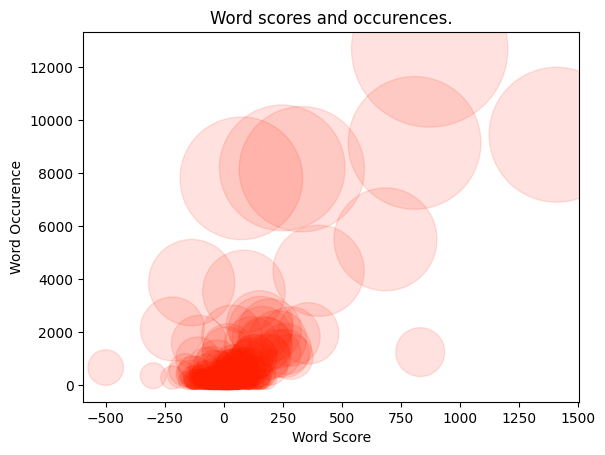

In [6]:
# Plot 
df_words.plot(y='Count',x='Score', s='Count', c='#FF1F0020', kind='scatter', xlabel='Word Score', ylabel='Word Occurence', title='Word scores and occurences.')

### Analysis

From the plot we can determine that:

1. our trainint data is unbalanced towards positive store.
2. We have many words centered acound zero score.

What we can do:

1. We SHOULD get a more varied data set that will give us a balanced distribution.
2. Filter out words around zero to optimize feature count.

Text(0.5, 1.0, 'Feature amount vs cut amount around origin')

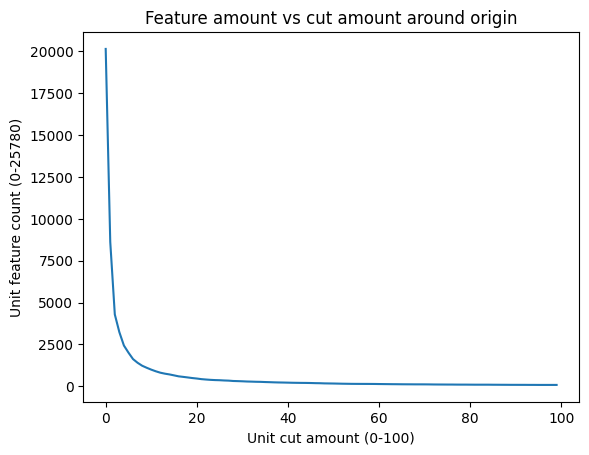

In [7]:
# Lets filter around zero
df_scores = df_words['Score']
cut_amounts = []
feat_counts = []
for cut in range(100):
    # cut amount
    cut_amounts.append(cut)
    # feature count at cut amount
    feat_cnt = df_scores[(df_scores < -cut) ^ (df_scores > cut)].shape[0]
    feat_counts.append(feat_cnt)
# plot
plt.plot(cut_amounts, feat_counts)
plt.xlabel(f'Unit cut amount (0-100)')
plt.ylabel(f'Unit feature count (0-{df_scores.shape[0]})')
plt.title('Feature amount vs cut amount around origin')

### Features
Let's limit features to around 500 by finding a cut amount around x axis.

In [8]:
cut_at = 0
for i in range(len(cut_amounts)):
    if feat_counts[i] > 500: continue
    else:
        cut_at = cut_amounts[i]
        break

print('Cut at:', cut_at)

Cut at: 19


### Data and fearure list

Compile and save our sentiment sample set and als oa list of our word features.

In [9]:

# Cut away 
words = list(df_words.query('Score < -@cut_at or Score > @cut_at')['Word'])
rows = []
row_count = len(TEXTS)
current = 0
print('Processing')
for sentiment,word_tuples in TEXTS:
    row = np.zeros(len(words)+1,dtype=np.float32)
    row[0] = sentiment
    for word,count in word_tuples:
        try:
            idx = words.index(word)+1
            row[idx] = count
        except: pass
    rows.append(row)
    current += 1
    if current % 2100 == 0:
        print(f'Row {current} of {row_count}.')

# Write feature list
print('Feature count:',len(words))
with open(join(*SOURCE_DATA_FOLDER,'features.json'),'w') as f:
    json.dump(words,f)

# Create feature dataframe
print('Creating DataFrame.')
df_features = pd.DataFrame(rows, columns=['SCORE']+words)
print('Writing DataFrame to file.')
df_features.to_csv(join(*SOURCE_DATA_FOLDER,'sentiment.csv'))
print('Bye.')

Processing
Row 2100 of 21440.
Row 4200 of 21440.
Row 6300 of 21440.
Row 8400 of 21440.
Row 10500 of 21440.
Row 12600 of 21440.
Row 14700 of 21440.
Row 16800 of 21440.
Row 18900 of 21440.
Row 21000 of 21440.
Feature count: 491
Creating DataFrame.
Writing DataFrame to file.
Bye.
